#  Evaluating the sensitivity of recall to different splits

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib
import random

In [2]:
import ipywidgets
import time

In [3]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [5]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [6]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [8]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

### Define experiment parameters
These are some key hyperparameters we're using for this experiment, such as input features and number of splits, and the hyperparameter fed to the tree object, such as max depth.

In [9]:
experiment_name = 'nb_decisionTree_cv_noHPT_country'

classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {}
classifier_name = 'decision_tree_cv'
suffix='country'
classifier_opts = {
    'max_depth': 20, 
    'min_samples_leaf': 1, 
    'criterion': 'gini',
}
cv_metrics = ['recall_micro', 'precision_micro', 'f1_micro']
hp_tune_metric = 'recall_micro'

In [10]:
input_feature_names = ['max_depth', 'year', 'lat', 'lon', 'country']
target_feature = 'instrument'
splitter_features = ['year', 'instrument']
unseen_feature = 'cruise_number'
ensemble_unseen_fraction = 0.1
num_unseen_splits = 5
unseen_fraction = 1.0 / num_unseen_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
unseen_fold_name = 'unseen_fold'

In [11]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [12]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'nb_outputs'

In [13]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [14]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/nb_outputs/nb_decisionTree_cv_noHPT_country


In [15]:
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

## Running the cross validation experiment

There are multiple levels to the experiment we want to run. The first to train on part of the data and then test on another part. We want to divide up the profiles by cruise, so the test data consists of cruises that were not seen in the training data. We then want to train a model for each of the possible train/test splits. We divide the model into "folds", and then each splits uses data in fold n as the test set and ther rest as the train, as is standard in machine learning. 

In this case calculate the fold labels manually rather than using standard functions so we can divide based on cruise number and assign profiles to a fold based on which cruise they come from. This is based on the analysis in the data exploration notebook, which shows that some unlabelled profiles come from cruises with no labelled profiles. We want to check that our algorithm will generalise well to such profiles, so we simulate this in the labelled data by setting aside whole cruises to not be used in training but rather in final evaluation.


We train one algorithm for each fold in the cross validation, which is the same process process as in the first notebook without cross-validation.

More information on the approach taken here and the spceific classes and function used can found in the following links:

scikit-learn API documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

discussion of cross-validationand hyperparameters for decision trees:
* https://scikit-learn.org/stable/modules/cross_validation.html
* https://stackoverflow.com/questions/60996995/use-groupkfold-in-nested-cross-validation-using-sklearn
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
* https://scikit-learn.org/stable/modules/tree.html


In [16]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 48.3 s, sys: 15.4 s, total: 1min 3s
Wall time: 1min 7s


In [17]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 196 ms, sys: 37.3 ms, total: 233 ms
Wall time: 231 ms


In [18]:
_ = xbt_labelled.get_ml_dataset(return_data=False)

In [19]:
_ = xbt_labelled.filter_features(xbt.dataset.TARGET_FEATURES).encode_target(return_data = False)

### Outer split for ensemble testing
As part of this experiment, we will be combining the classifiers on trained each of the splits by using the output of each as avote, and then calculating a pseudo-probability based on the voting. In order to compare the performance of the ensemble voting classifier results with individual classifiers, we need some data that has not been used to train the ensemble. Each individual classifier created excludes a fold of the data for testing by default as part of cross-validation, which is good ML practice. But when all the classifiers are combined, the ensemble has been trained on all the data presented to the cross-validation algorithm, so we need a separate test set for evaluating the metrics of the ensemble classifier. So as for inside cross-validation, we will select some cruises which we hold back and then use at the end for evaluation.

In [20]:
# ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction, split_feature='year')    
ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction)    
xbt_ens_unseen = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_ens_working = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

In [21]:
%%time
#TODO: ensure split is even by year and instrument
# this can be done by selecting each year in turn, getting the cruises for that year, then randomising th e list using random.shuffle 
# and selecting the first n items, where n = m *(1 /f) where m is total items in the year and f is the number of splits
xbt_ens_working.generate_folds_by_feature('cruise_number', num_unseen_splits, unseen_fold_name)

CPU times: user 26.9 s, sys: 52.3 ms, total: 27 s
Wall time: 27 s


In [22]:
X_labelled = xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]


## Running different splits

We would like to compare the results we get for the unseen data, which is excluded from the CV/HPT process) for different splits of the data for cross-validation and hyperparameter tuning. Different ways of splitting could include:

* random splitting
* splitting by cruise number
* stratified splitting
* hyperparameter tuning with cruise-based split for outer CV and random inner split.
* shuffling turned off or on


In [23]:
scores_dict = {}

### Splitting by cruise

In [25]:
%%time
scores_dict['split_by_cruise'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.GroupKFold(n_splits=num_unseen_splits),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 297 ms, sys: 567 ms, total: 864 ms
Wall time: 42.5 s


### Random splitting with pre-shuffling

In [26]:
%%time
scores_dict['split_random_with_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.KFold(n_splits=num_unseen_splits, 
                                     random_state=random.randint(1,2**20), 
                                     shuffle=True),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 211 ms, sys: 332 ms, total: 543 ms
Wall time: 39.1 s


### Random splitting without pre-shuffling

In [27]:
%%time
scores_dict['split_random_no_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.KFold(n_splits=num_unseen_splits, 
                                     shuffle=False),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 144 ms, sys: 311 ms, total: 455 ms
Wall time: 39.9 s


### Stratified Splitting

In [43]:
%%time
scores_dict['split_stratified__with_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.StratifiedKFold(n_splits=num_unseen_splits, 
                                               shuffle=True, 
                                               random_state=random.randint(1,2**20)),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 487 ms, sys: 793 ms, total: 1.28 s
Wall time: 42.3 s


In [49]:
%%time
scores_dict['split_stratified_no_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.StratifiedKFold(n_splits=num_unseen_splits, 
                                               shuffle=False,
                                              ),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 326 ms, sys: 288 ms, total: 614 ms
Wall time: 36.5 s


### Initial results

Looking at the train and test scores reported by the cross-validatiom can give us an initial idea of the relative results. 

In [44]:
scores_dict.keys()

dict_keys(['split_by_cruise', 'split_random_with_shuffle', 'split_random_no_shuffle', 'split_stratified__with_shuffle'])

In [45]:
scores_dict['split_by_cruise']

{'fit_time': array([20.53183603, 21.65153813, 21.8758707 , 21.81995797, 13.11789775]),
 'score_time': array([0.44757867, 0.38288021, 0.3682096 , 0.36508203, 0.24471617]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.85240145, 0.93579465, 0.92554922, 0.9337786 , 0.93303345]),
 'train_recall_micro': array([0.98109196, 0.97360916, 0.97344913, 0.97488041, 0.97233369]),
 'test_precision_micro': array([0.85240145, 0.93579465, 0.92554922, 0.9337786 , 0.93303345]),
 'train_precision_micro': array([0.98109196, 0.97360916, 0.97344913, 0.97488041, 0.97233369]),
 'test_f1_micro': array([0.85240145, 0.93579465, 0.92554922, 0.9337786 , 0.93303345]),
 'train_f1_micro': array([0.98109196, 0.97360916, 0.97344913, 0.97488041, 0.97233369])}

In [46]:
scores_dict['split_random_with_shuffle']

{'fit_time': array([22.7938168 , 22.30360532, 22.71035194, 22.37799358, 12.56996131]),
 'score_time': array([0.41590261, 0.39087343, 0.4069047 , 0.42092347, 0.27058673]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.95480308, 0.95499702, 0.95709638, 0.9576491 , 0.9559764 ]),
 'train_recall_micro': array([0.97297736, 0.97273252, 0.97446583, 0.97407916, 0.9744331 ]),
 'test_precision_micro': array([0.95480308, 0.95499702, 0.95709638, 0.9576491 , 0.9559764 ]),
 'train_precision_micro': array([0.97297736, 0.97273252, 0.97446583, 0.97407916, 0.9744331 ]),
 'test_f1_micro': array([0.95480308, 0.95499702, 0.95709638, 0.9576491 , 0.9559764 ]),
 'train_f1_micro': array([0.97297736, 0.97273252, 0.97446583, 0.97407916, 0.9744331 ])}

In [47]:
scores_dict['split_random_no_shuffle']

{'fit_time': array([25.17610478, 24.92549014, 24.36277533, 25.4422853 , 13.85224414]),
 'score_time': array([0.45446205, 0.42334223, 0.4041121 , 0.62518072, 0.29560733]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.95669881, 0.95518611, 0.95696063, 0.95712062, 0.95675699]),
 'train_recall_micro': array([0.97376523, 0.97272282, 0.97451067, 0.97471552, 0.97465491]),
 'test_precision_micro': array([0.95669881, 0.95518611, 0.95696063, 0.95712062, 0.95675699]),
 'train_precision_micro': array([0.97376523, 0.97272282, 0.97451067, 0.97471552, 0.97465491]),
 'test_f1_micro': array([0.95669881, 0.95518611, 0.95696063, 0.95712062, 0.95675699]),
 'train_f1_micro': array([0.97376523, 0.97272282, 0.97451067, 0.97471552, 0.97465491])}

In [48]:
scores_dict['split_stratified__with_shuffle']

{'fit_time': array([21.50900221, 21.54068756, 21.53230405, 21.3715384 , 12.02836609]),
 'score_time': array([0.38711977, 0.39738417, 0.39980841, 0.39828587, 0.2657752 ]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.95538004, 0.95604912, 0.95682487, 0.95714971, 0.95677639]),
 'train_recall_micro': array([0.97222101, 0.97292645, 0.97424037, 0.97413977, 0.97475673]),
 'test_precision_micro': array([0.95538004, 0.95604912, 0.95682487, 0.95714971, 0.95677639]),
 'train_precision_micro': array([0.97222101, 0.97292645, 0.97424037, 0.97413977, 0.97475673]),
 'test_f1_micro': array([0.95538004, 0.95604912, 0.95682487, 0.95714971, 0.95677639]),
 'train_f1_micro': array([0.97222101, 0.97292645, 0.97424037, 0.97413977, 0.97475673])}

In [50]:
scores_dict['split_stratified_no_shuffle']

{'fit_time': array([20.61250114, 20.61301661, 20.60697627, 21.54317355, 11.77463865]),
 'score_time': array([0.38571405, 0.35720062, 0.37808132, 0.37396193, 0.25744605]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.56723054, 0.35048702, 0.59504589, 0.71339084, 0.08314546]),
 'train_recall_micro': array([0.98366327, 0.97773972, 0.97102103, 0.98230086, 0.97585975]),
 'test_precision_micro': array([0.56723054, 0.35048702, 0.59504589, 0.71339084, 0.08314546]),
 'train_precision_micro': array([0.98366327, 0.97773972, 0.97102103, 0.98230086, 0.97585975]),
 'test_f1_micro': array([0.56723054, 0.35048702, 0.59504589, 0.71339084, 0.08314546]),
 'train_f1_micro': array([0.98366327, 0.97773972, 0.97102103, 0.98230086, 0.97585975])}

## Generate probabilities and evaluate

As we have trained multiple algorithms, one for each split, we can combine the results using the output from each as a vote. We can then find the ensemble classifaication by choosing the probe type with the most votes. This can be formulated as a pseudo probability, by adding up number of votes and dividing by the number of classifiers so the values sum to one. This gives an idea of uncertainty. Where all classifiers agree and the probability is 1, then we are confident in the classification. Where the probability is less than one, classifiers do not all agree and we are less certain.


In [30]:
result_feature_template = 'instrument_res_dt_split{split_num}'

In [51]:
%%time
df_ens_working_dict = {}
df_ens_unseen_dict = {}
vote_count_working_dict = {}
vote_count_unseen_dict = {} 
result_feature_names_dict = {}
for fold_type, scores in scores_dict.items():
    res_ens_working = {'id': xbt_ens_working.xbt_df['id']}
    res_ens_unseen = {'id': xbt_ens_unseen.xbt_df['id']}
    vote_count_working_dict[fold_type] = numpy.zeros([xbt_ens_working.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
    vote_count_unseen_dict[fold_type] = numpy.zeros([xbt_ens_unseen.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
    result_feature_names_dict[fold_type] = []
    # classifications_df = None
    for split_num, estimator in enumerate(scores['estimator']):
        res_name = result_feature_template.format(split_num=split_num)
        result_feature_names_dict[fold_type] += [res_name]
        res_ml1_working = estimator.predict(xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0])
        res2_working = xbt_ens_working._feature_encoders[target_feature].inverse_transform(res_ml1_working).reshape(-1,1)
        res_ens_working[res_name] = res2_working.reshape(-1)
        vote_count_working_dict[fold_type] += xbt_ens_working._target_encoders[target_feature].transform(res2_working)

        res_ml1_unseen = estimator.predict(xbt_ens_unseen.filter_features(input_feature_names).get_ml_dataset()[0])
        res2_unseen = xbt_ens_unseen._feature_encoders[target_feature].inverse_transform(res_ml1_unseen).reshape(-1,1)
        res_ens_unseen[res_name] = res2_unseen.reshape(-1)
        vote_count_unseen_dict[fold_type] += xbt_ens_unseen._target_encoders[target_feature].transform(res2_unseen)

    df_ens_working_dict[fold_type] = pandas.DataFrame(res_ens_working)
    df_ens_unseen_dict[fold_type] = pandas.DataFrame(res_ens_unseen)

    vote_count_working_dict[fold_type] /= float(len(res_ens_working.keys()))    
    vote_count_unseen_dict[fold_type] /= float(len(res_ens_working.keys()))    
scores = None

CPU times: user 26.6 s, sys: 23.2 s, total: 49.7 s
Wall time: 49.7 s


In [53]:
max_prob_feature_name = f'{target_feature}_max_prob'
for fold_type in scores_dict.keys():
    res_working_ensemble = vote_count_working_dict[fold_type].argmax(axis=1)
    instr_res_working_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_working_ensemble)
    df_ens_working_dict[fold_type][max_prob_feature_name] = instr_res_working_ensemble
    res_unseen_ensemble = vote_count_unseen_dict[fold_type].argmax(axis=1)
    instr_res_unseen_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_unseen_ensemble)
    df_ens_unseen_dict[fold_type][max_prob_feature_name] = instr_res_unseen_ensemble

In [54]:
for fold_type in scores_dict.keys():
    df_ens_working_dict[fold_type] = pandas.merge(df_ens_working_dict[fold_type], xbt_ens_working.xbt_df[['id', 'year']])
    df_ens_unseen_dict[fold_type] = pandas.merge(df_ens_unseen_dict[fold_type], xbt_ens_unseen.xbt_df[['id', 'year']])

In [55]:
metrics_df_ens_dict = {}
for fold_type in scores_dict.keys():
    df_ens_working = df_ens_working_dict[fold_type]
    df_ens_unseen = df_ens_unseen_dict[fold_type]
    metric_list_ens = []
    for year in range(year_range[0],year_range[1]):
        y_ens_working = xbt_ens_working.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
        y_ens_unseen = xbt_ens_unseen.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
        y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working[df_ens_working.year == year]['instrument_max_prob'])    
        y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen[df_ens_unseen.year == year]['instrument_max_prob'])    
        cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)
        prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
            y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))
        prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
            y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data='ens_working', metric='precision', subset='all'): prec_ens_working,
                       column_template.format(data='ens_working', metric='recall', subset='all'): recall_ens_working,
                       column_template.format(data='ens_working', metric='f1', subset='all'): f1_ens_working,
                       column_template.format(data='ens_unseen', metric='precision', subset='all'): prec_ens_unseen,
                       column_template.format(data='ens_unseen', metric='recall', subset='all'): recall_ens_unseen,
                       column_template.format(data='ens_unseen', metric='f1', subset='all'): f1_ens_unseen,
                      }

        metric_list_ens += [metric_dict]
    metrics_df_ens_dict[fold_type] = pandas.DataFrame.from_records(metric_list_ens)    

In [56]:
cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)

In [58]:
scores_ens_working = {}
scores_ens_unseen = {}

In [59]:
for fold_type in scores_dict.keys():
    y_ens_working = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working_dict[fold_type]['instrument_max_prob'])    
    prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
        y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))

    column_template = '{metric}_{data}_{subset}'
    scores_ens_working[fold_type] = {
        'name': 'ens_working',
        'subset': 'train',
        'precision_all': prec_ens_working,
        'recall_all': recall_ens_working,
        'f1_all': f1_ens_working,
        'support_all': support_ens_working,
    }


In [60]:
for fold_type in scores_dict.keys():
    y_ens_unseen = xbt_ens_unseen.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen_dict[fold_type]['instrument_max_prob'])    
    prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
        y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))
    scores_ens_unseen[fold_type] = {
        'name': 'ens_unseen',
        'subset': 'unseen',
        'precision_all': prec_ens_unseen,
        'recall_all': recall_ens_unseen,
        'f1_all': f1_ens_unseen,
        'support_all': f1_ens_unseen,
    }


## Plotting results of cross-validation and hyperparameter tuning
In this section we will take a look at the results from the cross validation and hyperparameter tuning of the decision tree to the XBT labelled data. To gain greater understanding, we seprately score the train and test sets for each year of the data and each class of instrument label. This is calculated separately for eeach of the estimators trained for the outer cross-validation (based on cruise numbers). We calculate the recall, precision and f1 metrics both for each class and averaged over all classes.

In [63]:
def generate_metrics(clf, xbt_ds, data_label, target_feature, input_feature_names, year_range, subset):
    metric_list = []
    for year in range(year_range[0],year_range[1]):
        X_year = xbt_ds.filter_obs({'year': year}, ).filter_features(input_feature_names).get_ml_dataset()[0]
        y_year = xbt_ds.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]

        y_res_year = clf.predict(X_year)
        cats = list(xbt_ds._feature_encoders[target_feature].classes_)
        prec_year, recall_year, f1_year, support_year = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, average='micro', labels=range(0,len(cats)))
        prec_cat, recall_cat, f1_cat, support_cat = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data=data_label, metric='precision', subset='all'): prec_year,
                       column_template.format(data=data_label, metric='recall', subset='all'): recall_year,
                       column_template.format(data=data_label, metric='f1', subset='all'): f1_year,
                       column_template.format(data=data_label, metric='support', subset='all'): support_year,
                      }

        metric_dict.update({column_template.format(data=data_label, metric='precision', subset=cat): val for cat, val in zip(cats, prec_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='recall', subset=cat): val for cat, val in zip(cats, recall_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='f1', subset=cat): val for cat, val in zip(cats, f1_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='support', subset=cat): val for cat, val in zip(cats, support_cat)})
        metric_list += [metric_dict]

    metrics_df = pandas.DataFrame.from_records(metric_list)
    
    X_full = xbt_ds.filter_features(input_feature_names).get_ml_dataset()[0]
    y_full = xbt_ds.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_full = clf.predict(X_full)
    prec_full, recall_full, f1_full, support_full = sklearn.metrics.precision_recall_fscore_support(
            y_full, y_res_full, average='micro')
    metrics_full = {
        'name': data_label,
        'subset': subset,
        'precision_all': prec_full,
        'recall_all': recall_full,
        'f1_all': f1_full,
        'support_all': support_full,
        }    
    return metrics_df, metrics_full

In [86]:
%%time
scores_df_dict = {}
metrics_dict = {}
for fold_type, scores in scores_dict.items():
    print(f'generating scores by year for {fold_type}')
    metrics_list = {}
    scores_list = [scores_ens_working[fold_type], scores_ens_unseen[fold_type]]
    for split_num, estimator in enumerate(scores['estimator']):
        xbt_train = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='exclude')
        xbt_test = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='include')
        train_metrics, train_scores = generate_metrics(estimator, xbt_train, 'train_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'train' )
        test_metrics, test_scores = generate_metrics(estimator, xbt_test, 'test_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'test')
        unseen_metrics, unseen_scores = generate_metrics(estimator, xbt_ens_unseen, 'unseen_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'unseen')
        scores_list += [train_scores, test_scores, unseen_scores]
        metrics_list[split_num] = pandas.merge(pandas.merge(train_metrics, test_metrics, on='year'), unseen_metrics, on='year')
    scores_df_dict[fold_type] = pandas.DataFrame.from_records(scores_list)
    metrics_dict[fold_type] = metrics_list
scores=None
fold_type=None

generating scores by year for split_by_cruise
generating scores by year for split_random_with_shuffle
generating scores by year for split_random_no_shuffle
generating scores by year for split_stratified__with_shuffle
generating scores by year for split_stratified_no_shuffle
CPU times: user 3min 23s, sys: 48.3 s, total: 4min 11s
Wall time: 4min 11s


In [87]:
d1 = {'name': scores_df_dict['split_by_cruise']['name']}
d1.update({f'recall_{k1}' : v1['recall_all'] for k1,v1 in scores_df_dict.items()})
pandas.DataFrame(d1)

,name,recall_split_by_cruise,recall_split_random_with_shuffle,recall_split_random_no_shuffle,recall_split_stratified__with_shuffle,recall_split_stratified_no_shuffle
0,ens_working,0.975515,0.974931,0.974819,0.974513,0.976914
1,ens_unseen,0.940268,0.940834,0.939878,0.940908,0.940945
2,train_0,0.946183,0.969107,0.970415,0.968916,0.901578
3,test_0,0.981324,0.970310,0.970092,0.968594,0.895433
4,unseen_0,0.929704,0.936168,0.935454,0.934397,0.869916
5,train_1,0.966606,0.973025,0.973104,0.973395,0.851452
6,test_1,0.963565,0.955403,0.955256,0.955750,0.855294
7,unseen_1,0.933785,0.932319,0.934916,0.934545,0.828419
8,train_2,0.961119,0.970122,0.970190,0.969772,0.895678
9,test_2,0.976762,0.974715,0.974469,0.974971,0.896459


<AxesSubplot:xlabel='name'>

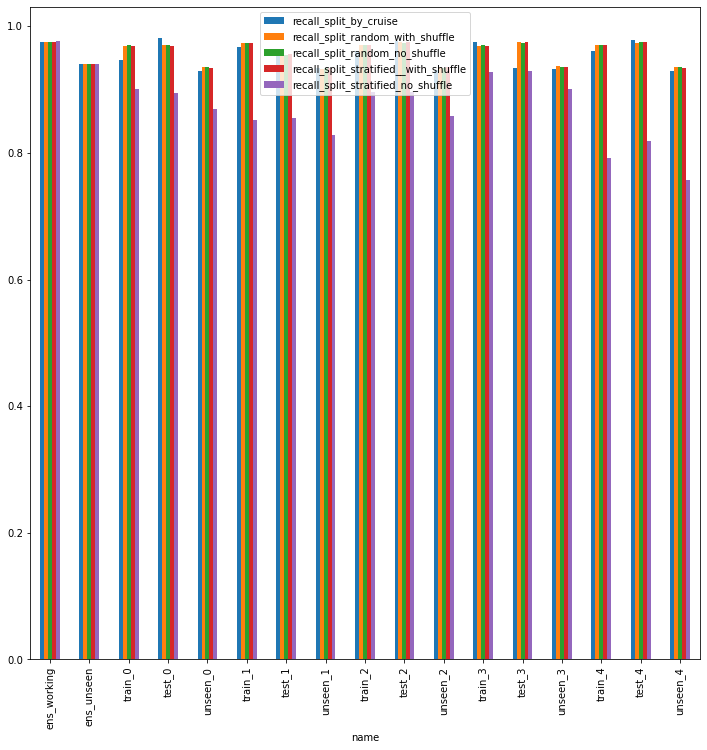

In [88]:
pandas.DataFrame(d1).plot.bar(x='name',figsize=(12,12))

In [107]:
sn1 = 0
subset1 = 'unseen'
[v1[sn1][['year', f'recall_{subset1}_{sn1}_all']] for k1,v1 in metrics_dict.items()]

[    year  recall_unseen_0_all
 0   1966             0.985401
 1   1967             1.000000
 2   1968             0.977391
 3   1969             0.935358
 4   1970             0.942529
 5   1971             0.949080
 6   1972             0.936427
 7   1973             0.979128
 8   1974             0.972921
 9   1975             0.947715
 10  1976             0.872382
 11  1977             0.939604
 12  1978             0.945093
 13  1979             0.931684
 14  1980             0.924224
 15  1981             0.986199
 16  1982             0.958045
 17  1983             0.955872
 18  1984             0.963465
 19  1985             0.974316
 20  1986             0.957983
 21  1987             0.989165
 22  1988             0.941827
 23  1989             0.846978
 24  1990             0.861671
 25  1991             0.890538
 26  1992             0.880330
 27  1993             0.925539
 28  1994             0.934743
 29  1995             0.892148
 30  1996             0.906840
 31  199

<AxesSubplot:xlabel='year'>

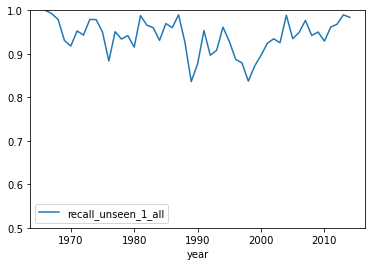

In [102]:
metrics_dict['split_by_cruise'][1].plot(x='year', y=f'recall_unseen_1_all',ylim=[0.5,1.0])

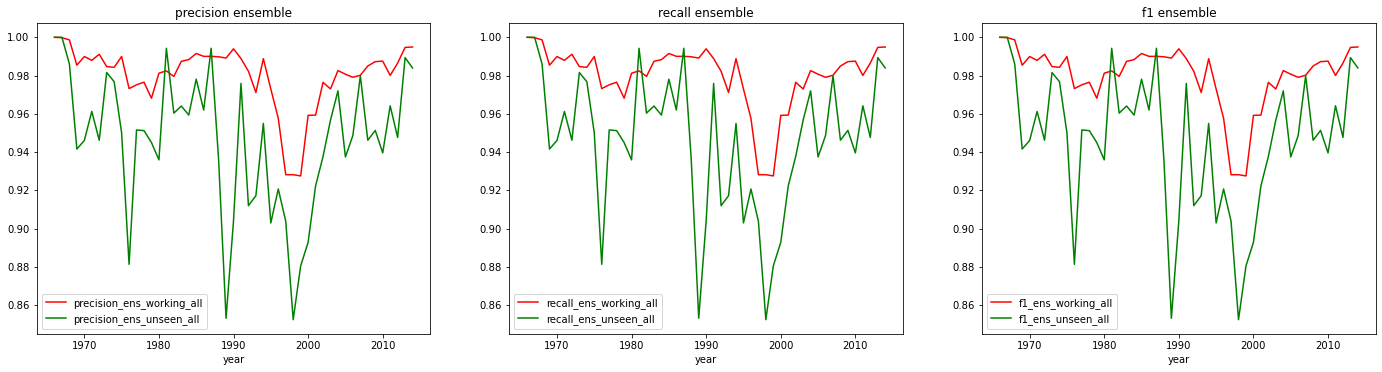

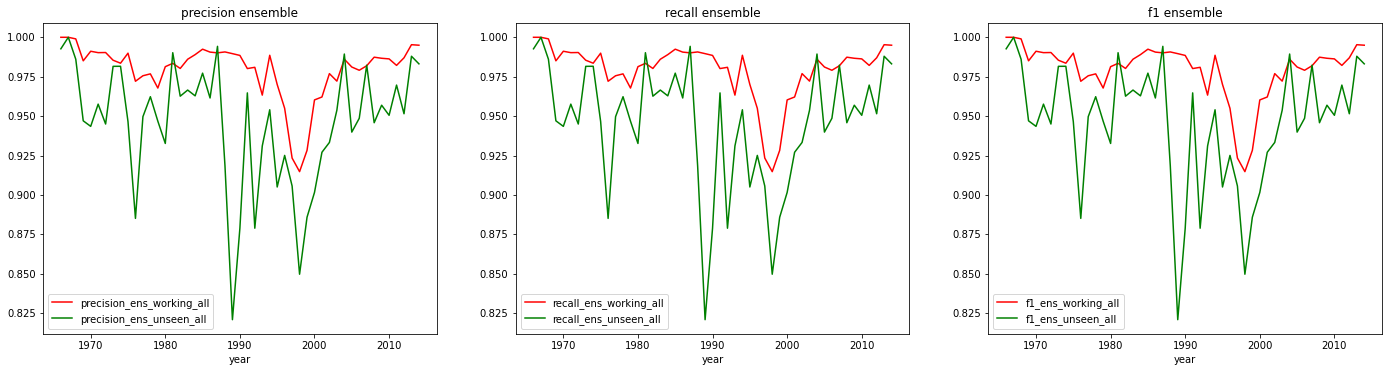

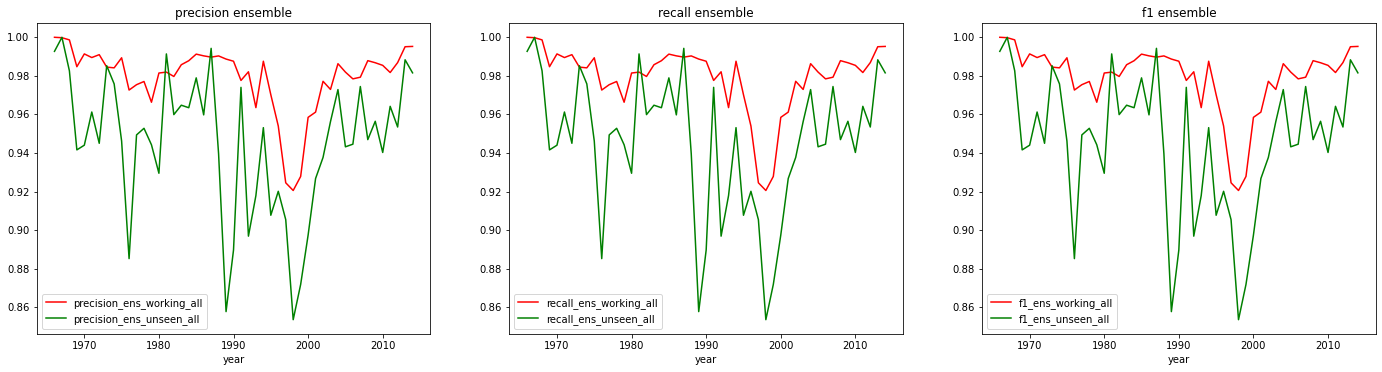

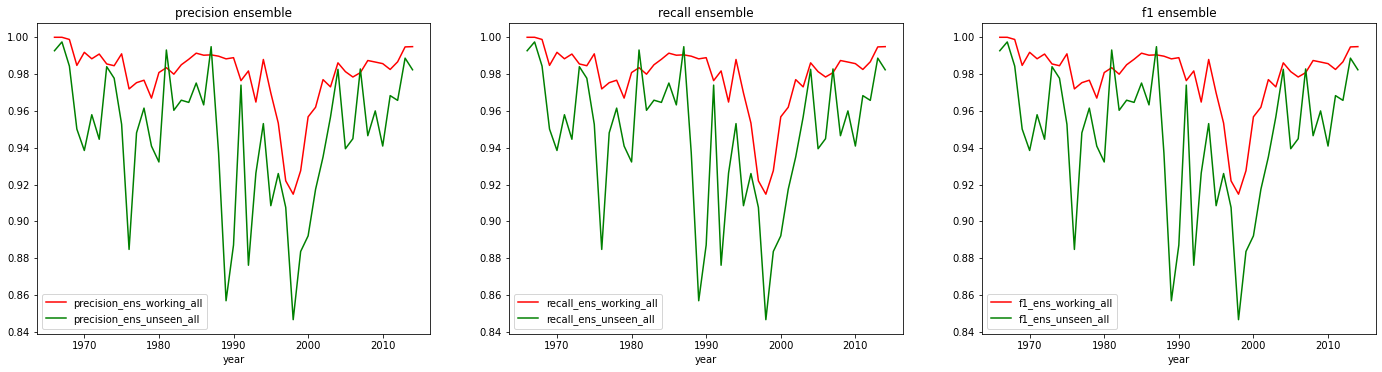

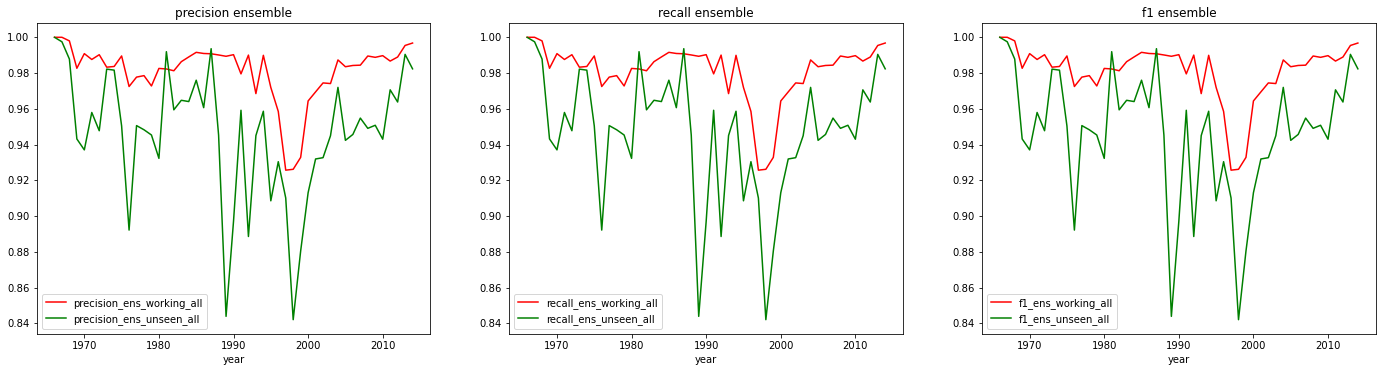

In [82]:
for fold_type, scores in scores_dict.items():
    fig_results = matplotlib.pyplot.figure(f'xbt_results_{fold_type}',figsize=(24,40))
    ax_precision = fig_results.add_subplot(6,3,1, title='precision ensemble')
    metrics_df_ens_dict[fold_type].plot.line(x='year',y=['precision_ens_working_all', 'precision_ens_unseen_all'], ax=ax_precision,color=['r','g'])
    ax_recall = fig_results.add_subplot(6,3,2, title='recall ensemble')
    metrics_df_ens_dict[fold_type].plot.line(x='year',y=['recall_ens_working_all', 'recall_ens_unseen_all'],ax=ax_recall,color=['r','g'])
    ax_f1 = fig_results.add_subplot(6,3,3, title='f1 ensemble')
    metrics_df_ens_dict[fold_type].plot.line(x='year',y=['f1_ens_working_all', 'f1_ens_unseen_all'],ax=ax_f1,color=['r','g'])

# for label1, metrics1  in metrics_list.items():
#     ax_precision = fig_results.add_subplot(6,3,label1*3 +4, title='precision split {0}'.format(label1))
#     ax_recall = fig_results.add_subplot(6,3,label1*3 + 4 + 1, title='recall split {0}'.format(label1))
#     ax_f1 = fig_results.add_subplot(6,3,label1*3 + 4 + 2, title='f1 split {0}'.format(label1))
#     metrics1.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all', f'precision_unseen_{label1}_all' ], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all', f'recall_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all',f'f1_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))

Also of interest is what hyper parameters were chosen by the GridCV hyperparameter tuning process. The following listing shows which parameters result in the best results for each split. We see that limiting the number of nodes resulted in better performance and restricting how nodes could split (min_samples_leaf) also varied based o the split. Varying these parameters results in different classifications so we get some profiles with different class assignments between different classifiers.

In [ ]:
fold_type = folds_list[1]
fig_results = matplotlib.pyplot.figure(f'xbt_results_{fold_type}',figsize=(24,40))

ax_precision = fig_results.add_subplot(6,3,1, title='precision ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['precision_ens_working_all', 'precision_ens_unseen_all'], ax=ax_precision,color=['r','g'])
ax_recall = fig_results.add_subplot(6,3,2, title='recall ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['recall_ens_working_all', 'recall_ens_unseen_all'],ax=ax_recall,color=['r','g'])
ax_f1 = fig_results.add_subplot(6,3,3, title='f1 ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['f1_ens_working_all', 'f1_ens_unseen_all'],ax=ax_f1,color=['r','g'])

# for label1, metrics1  in metrics_list.items():
#     ax_precision = fig_results.add_subplot(6,3,label1*3 +4, title='precision split {0}'.format(label1))
#     ax_recall = fig_results.add_subplot(6,3,label1*3 + 4 + 1, title='recall split {0}'.format(label1))
#     ax_f1 = fig_results.add_subplot(6,3,label1*3 + 4 + 2, title='f1 split {0}'.format(label1))
#     metrics1.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all', f'precision_unseen_{label1}_all' ], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all', f'recall_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all',f'f1_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))

In [ ]:
fold_type = folds_list[2]
fig_results = matplotlib.pyplot.figure(f'xbt_results_{fold_type}',figsize=(24,40))

ax_precision = fig_results.add_subplot(6,3,1, title='precision ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['precision_ens_working_all', 'precision_ens_unseen_all'], ax=ax_precision,color=['r','g'])
ax_recall = fig_results.add_subplot(6,3,2, title='recall ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['recall_ens_working_all', 'recall_ens_unseen_all'],ax=ax_recall,color=['r','g'])
ax_f1 = fig_results.add_subplot(6,3,3, title='f1 ensemble')
metrics_df_ens_dict[fold_type].plot.line(x='year',y=['f1_ens_working_all', 'f1_ens_unseen_all'],ax=ax_f1,color=['r','g'])

# for label1, metrics1  in metrics_list.items():
#     ax_precision = fig_results.add_subplot(6,3,label1*3 +4, title='precision split {0}'.format(label1))
#     ax_recall = fig_results.add_subplot(6,3,label1*3 + 4 + 1, title='recall split {0}'.format(label1))
#     ax_f1 = fig_results.add_subplot(6,3,label1*3 + 4 + 2, title='f1 split {0}'.format(label1))
#     metrics1.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all', f'precision_unseen_{label1}_all' ], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all', f'recall_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))
#     metrics1.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all',f'f1_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))

In [ ]:
fig_results2 = matplotlib.pyplot.figure('xbt_results2',figsize=(12,12))
ax_recall2 = fig_results2.add_subplot(1,1,1, title='recall by year')
for label1, metrics1  in metrics_list.items():
    metrics_list[0]['recall_unseen_0_all']
    metrics1.plot.line(ax=ax_recall2, x='year', y=[ f'recall_unseen_{label1}_all'], color=['b', ], ylim=(0.4,1.0))

metrics_df_ens.plot.line(x='year',y=['recall_ens_unseen_all'],ax=ax_recall2,color=['r',],linewidth=3)


In [ ]:
metrics_df_merge = None
for label1, metrics1  in metrics_list.items():
    if metrics_df_merge is None:
        metrics_df_merge = metrics1
    else:
        metrics_df_merge = pandas.merge(metrics_df_merge, metrics1, on='year')

In [ ]:
# merge in ensemble metrics
metrics_df_merge = pandas.merge(metrics_df_merge, metrics_df_ens, on='year')

In [ ]:
results_output_path = os.path.join(xbt_output_dir,
                                   result_fname_template.format(classifier=classifier_name, 
                                                                suffix=suffix))
# metrics_df_merge.to_csv(results_output_path)

### Outputting the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [ ]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [ ]:
%%time
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [ ]:
%%time
result_feature_names = []
# classifications_df = None
for split_num, estimator in enumerate(scores['estimator']):
    res_name = result_feature_template.format(split_num=split_num)
    result_feature_names += [res_name]
    res_ml1 = estimator.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
    res2 = list(xbt_labelled._feature_encoders[target_feature].inverse_transform(res_ml1).reshape(-1))
    xbt_predictable.xbt_df[res_name] = res2
    # Use the recorded instrument type where it exists (i.e. don't  overwrite with ML prediction)
    xbt_predictable.xbt_df.loc[xbt_labelled.xbt_df.index, res_name] = xbt_predictable.xbt_df.loc[xbt_labelled.xbt_df.index, target_feature]

In [ ]:
def imeta_instrument(row1):
    return 'XBT: {t1[0]} ({t1[1]})'.format(t1=imeta_classification(row1))

In [ ]:
%%time
imeta_output_flags = []
for res_name in result_feature_names:
    flag_name = f'imeta_applied_{res_name}'
    imeta_output_flags += [flag_name]
    xbt_predictable.xbt_df[flag_name] = 0
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, flag_name] = 1
    xbt_predictable.xbt_df[flag_name] = xbt_predictable.xbt_df[flag_name].astype('int8')
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, res_name] = \
        xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].apply(imeta_instrument, axis=1)



In [ ]:
%%time
fv_dict = {rfn1: UNKNOWN_STR for rfn1 in result_feature_names}
fv_dict.update({f1: 1 for f1 in imeta_output_flags})
xbt_full_dataset.merge_features(xbt_predictable, result_feature_names + imeta_output_flags,
                               fill_values = fv_dict,
                               feature_encoders={rfn1: xbt_labelled._feature_encoders[target_feature] for rfn1 in result_feature_names},
                               target_encoders={rfn1: xbt_labelled._target_encoders[target_feature] for rfn1 in result_feature_names},                                
                                output_formatters={rfn1: cat_output_formatter for rfn1 in result_feature_names})

In [ ]:
%%time
xbt_unknown_inputs = xbt_full_dataset.filter_obs({dataexploration.xbt_dataset.PREDICTABLE_FLAG: 0})
imeta_instrument_fallback = xbt_unknown_inputs.xbt_df.apply(imeta_instrument, axis=1)
for res_name in result_feature_names:
    xbt_full_dataset.xbt_df.loc[xbt_unknown_inputs.xbt_df.index, res_name] = imeta_instrument_fallback

The classifier is unable to predict a class for some of the profiles. This can be either because the classifier cannot produce a result, or because the country is not present in the labelled dataset. In these cases iMeta is used as a fallback. This plot shows for what proportion of profiles this occurs.

In [ ]:
pandas.DataFrame.from_records([dict(zip(['ML tree','imeta'] ,xbt_full_dataset.xbt_df[imf1].value_counts().values)) for imf1 in imeta_output_flags]).plot(kind='bar',stacked=True,title='Number of profiles falling back on iMeta', figsize=(12,12))

Of interest in our classifier ensemble is how many profiles are labelled differently by different classifiers. Here we count the different labels for each profile. We say that the ajority get only 1 label, but a substantial minority get 2 ior 3 labels, and some get as many as 5 (a different classification from each trained instance of the classifier!). For those profile which have been assigned more that one label, we can assign probabilities based on the number of classifiers "voting" for each label. This is not a real probability, but give some idea of the confidence we have in assigned labels. It could also be used as a distribution from which to sample for an esemble temperature dataset.

In [ ]:
%%time
count1 = xbt_full_dataset.filter_features(result_feature_names).xbt_df.apply(lambda row1: len(set(row1.values)), axis='columns')

In [ ]:
count1.value_counts()

In [ ]:
%%time
vote_count_full = numpy.zeros([xbt_full_dataset.shape[0], len(xbt_full_dataset._target_encoders[result_feature_names[0]].categories_[0])],dtype=numpy.float64)
for res_name in result_feature_names:
    vote_count_full += xbt_full_dataset.filter_features([res_name]).encode_target()[0]
    
vote_count_full /= float(len(result_feature_names))

In [ ]:
res_full_ensemble = vote_count_full.argmax(axis=1)
instr_res_full_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_full_ensemble)

In [ ]:
%%time
vote_dict = {f'instrument_probability_{cat1}': vote_count_full[:,ix1] for ix1, cat1 in enumerate(xbt_full_dataset._target_encoders[target_feature].categories_[0])}
vote_dict.update({'id': xbt_full_dataset['id'],
                  max_prob_feature_name: instr_res_full_ensemble
                 })
vote_df = pandas.DataFrame(vote_dict)

Note about cross validation: one can jkeeping doing forever, but we have limited data to test meaningfully each of our choices
what choices have we made?
what choices could we test further - future work!

In [ ]:
xbt_full_dataset.xbt_df = xbt_full_dataset.xbt_df.merge(vote_df, on='id')

In [ ]:
# %%time
# xbt_full_dataset.output_data(os.path.join(xbt_output_dir, output_fname_template.format(classifier=classifier_name,
#                                                                                   suffix=suffix)),
#                              target_features=[])